In [ ]:
# Install packages
!python -m pip install -U pip setuptools wheel

# CRITICAL: Uninstall any existing PyTorch (CPU or CUDA) to avoid conflicts
!python -m pip uninstall torch torchvision torchaudio -y

# Install PyTorch with CUDA 12.8 support
!python -m pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu128

# Install other dependencies
!python -m pip install -U "gymnasium[atari]"
!python -m pip install opencv-python
!python -m pip install tqdm

Found existing installation: torch 2.9.1+cu128
Uninstalling torch-2.9.1+cu128:
  Successfully uninstalled torch-2.9.1+cu128
Found existing installation: torchvision 0.24.1+cu128
Uninstalling torchvision-0.24.1+cu128:
  Successfully uninstalled torchvision-0.24.1+cu128
Found existing installation: torchaudio 2.9.1+cu128
Uninstalling torchaudio-2.9.1+cu128:
  Successfully uninstalled torchaudio-2.9.1+cu128

INSTALLING PYTORCH WITH CUDA SUPPORT


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


Looking in indexes: https://download.pytorch.org/whl/cu128
  Using cached https://download.pytorch.org/whl/cu128/torch-2.9.1%2Bcu128-cp313-cp313-win_amd64.whl.metadata (29 kB)
  Using cached https://download.pytorch.org/whl/cu128/torchvision-0.24.1%2Bcu128-cp313-cp313-win_amd64.whl.metadata (6.1 kB)
  Using cached https://download.pytorch.org/whl/cu128/torchaudio-2.9.1%2Bcu128-cp313-cp313-win_amd64.whl.metadata (7.0 kB)
Using cached https://download.pytorch.org/whl/cu128/torch-2.9.1%2Bcu128-cp313-cp313-win_amd64.whl (2862.0 MB)
Using cached https://download.pytorch.org/whl/cu128/torchvision-0.24.1%2Bcu128-cp313-cp313-win_amd64.whl (9.6 MB)
Using cached https://download.pytorch.org/whl/cu128/torchaudio-2.9.1%2Bcu128-cp313-cp313-win_amd64.whl (2.2 MB)

   ---------------------------------------- 0/3 [torch]
   ---------------------------------------- 0/3 [torch]
   ---------------------------------------- 0/3 [torch]
   ---------------------------------------- 0/3 [torch]
   ------------

In [1]:
# Cell 1: Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import cv2
import gymnasium as gym
import ale_py  # Registers ALE environments
from collections import deque, namedtuple
from tqdm import tqdm
import random
import os

# Set device (must be done here so it's available globally)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\nUsing device: {device}")

print("Imports complete")


Using device: cuda
Imports complete


In [2]:
# Cell 2: Wrappers for Atari preprocessing
# Based on OpenAI Baselines but adapted for gymnasium

class NoopResetEnv(gym.Wrapper):
    """Sample initial states by taking random number of no-ops on reset."""
    def __init__(self, env, noop_max=30):
        super().__init__(env)
        self.noop_max = noop_max
        self.noop_action = 0
    
    def reset(self, **kwargs):
        obs, info = self.env.reset(**kwargs)
        if self.noop_max > 0:
            noops = np.random.randint(1, self.noop_max + 1)
            for _ in range(noops):
                obs, _, terminated, truncated, _ = self.env.step(self.noop_action)
                if terminated or truncated:
                    obs, info = self.env.reset(**kwargs)
        return obs, info


class MaxAndSkipEnv(gym.Wrapper):
    """Return only every `skip`-th frame, max-pooling across last 2 frames."""
    def __init__(self, env, skip=4):
        super().__init__(env)
        self._skip = skip
        self._obs_buffer = np.zeros((2,) + env.observation_space.shape, dtype=np.uint8)

    def step(self, action):
        total_reward = 0.0
        terminated = False
        truncated = False
        info = {}

        for i in range(self._skip):
            obs, reward, term, trunc, inf = self.env.step(action)

            # Always write the most recent observations; avoids stale frames if episode ends early
            self._obs_buffer[i % 2] = obs

            total_reward += reward
            terminated = terminated or term
            truncated = truncated or trunc
            info = inf

            if terminated or truncated:
                break

        max_frame = self._obs_buffer.max(axis=0)
        return max_frame, total_reward, terminated, truncated, info


class WarpFrame(gym.ObservationWrapper):
    """Warp frames to 84x84 grayscale as done in the Nature paper."""
    def __init__(self, env):
        super().__init__(env)
        self.width = 84
        self.height = 84
        self.observation_space = gym.spaces.Box(
            low=0, high=255, shape=(self.height, self.width), dtype=np.uint8
        )
    
    def observation(self, frame):
        if len(frame.shape) == 3:
            frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        frame = cv2.resize(frame, (self.width, self.height), interpolation=cv2.INTER_AREA)
        return frame


class ClipRewardEnv(gym.RewardWrapper):
    """Bin reward to {+1, 0, -1} by its sign."""
    def reward(self, reward):
        return np.sign(reward)


class FrameStack(gym.Wrapper):
    """Stack k last frames. Returns lazy array, which is much more memory efficient."""
    def __init__(self, env, k=4):
        super().__init__(env)
        self.k = k
        self.frames = deque([], maxlen=k)
        obs_shape = env.observation_space.shape
        self.observation_space = gym.spaces.Box(
            low=0, high=255, shape=(k, *obs_shape), dtype=np.uint8
        )
    
    def reset(self, **kwargs):
        obs, info = self.env.reset(**kwargs)
        for _ in range(self.k):
            self.frames.append(obs)
        return self._get_obs(), info
    
    def step(self, action):
        obs, reward, terminated, truncated, info = self.env.step(action)
        self.frames.append(obs)
        return self._get_obs(), reward, terminated, truncated, info
    
    def _get_obs(self):
        assert len(self.frames) == self.k
        return np.stack(self.frames, axis=0)

class FireResetEnv(gym.Wrapper):
    """Press FIRE button at the start of each episode to begin gameplay."""
    def __init__(self, env):
        super().__init__(env)
        # Action 1 is typically FIRE in Atari games
        # For Pong, we need to press FIRE to start the game
        self.fire_action = 1
    
    def reset(self, **kwargs):
        obs, info = self.env.reset(**kwargs)
        # Press FIRE to start the game
        obs, _, terminated, truncated, info = self.env.step(self.fire_action)
        if terminated or truncated:
            # If game ended immediately, reset again
            obs, info = self.env.reset(**kwargs)
        return obs, info


def make_atari_env(env_id='ALE/Pong-v5', max_episode_steps=108000, sticky_actions=False):
    """
    Create and wrap Atari environment.

    - Use ALE/Pong-v5 but force frameskip=1.
    - Then MaxAndSkipEnv(skip=4) becomes the ONLY frameskip.
    """
    env = gym.make(
        env_id,
        frameskip=1,  # critical: prevents 4x4=16 frame skipping
        repeat_action_probability=0.0,
        full_action_space=False,  # default is already reduced actions; keeping explicit
    )

    # (optional) keep your episode limit hack
    env._max_episode_steps = max_episode_steps

    env = NoopResetEnv(env, noop_max=30)
    env = FireResetEnv(env)  # ADD THIS - press FIRE to start game
    env = MaxAndSkipEnv(env, skip=4)
    env = WarpFrame(env)
    env = ClipRewardEnv(env)
    env = FrameStack(env, k=4)
    return env



# Test the wrapper
test_env = make_atari_env()
test_obs, _ = test_env.reset()
print(f"Observation shape: {test_obs.shape}, dtype: {test_obs.dtype}")
print(f"Action space: {test_env.action_space}")
test_env.close()

Observation shape: (4, 84, 84), dtype: uint8
Action space: Discrete(6)


In [3]:
# Cell 3: DQN Network Model

class DQNNetwork(nn.Module):
    """DQN CNN network for Atari games."""
    def __init__(self, n_actions, n_frames=4):
        super(DQNNetwork, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(n_frames, 32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        
        # Fully connected layers
        # Output size after conv layers: 7x7x64 = 3136
        self.fc1 = nn.Linear(7 * 7 * 64, 512)
        self.fc2 = nn.Linear(512, n_actions)
        
        # Initialize weights
        self._initialize_weights()
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        # Normalize to [0, 1]
        x = x.float() / 255.0
        
        # Convolutional layers
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        
        # Flatten
        x = x.view(x.size(0), -1)
        
        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x


# Test the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

test_model = DQNNetwork(n_actions=6, n_frames=4).to(device)
test_input = torch.zeros(1, 4, 84, 84, dtype=torch.uint8).to(device)
test_output = test_model(test_input)
print(f"Model setup\nInput shape: {test_input.shape}, Output shape: {test_output.shape}")

Using device: cuda
Model setup
Input shape: torch.Size([1, 4, 84, 84]), Output shape: torch.Size([1, 6])


In [4]:
# Cell 4: Replay Buffer (Memory-Optimized)

Experience = namedtuple('Experience', ['state', 'action', 'reward', 'next_state', 'done'])

class ReplayBuffer:
    """
    Memory-optimized experience replay buffer for DQN.
    Uses numpy arrays for efficient storage instead of deque.
    
    The capacity parameter acts as max_memory_length - when the buffer is full,
    new entries automatically overwrite the oldest entries (circular buffer).
    This prevents memory from growing unbounded.
    """
    def __init__(self, capacity=250000):  # capacity = max_memory_length (reduced from 1M to 250k to prevent MemoryError)
        self.capacity = capacity
        self.size = 0
        self.ptr = 0
        
        # Pre-allocate numpy arrays for efficient storage
        # State shape: (4, 84, 84) uint8
        self.states = np.zeros((capacity, 4, 84, 84), dtype=np.uint8)
        self.next_states = np.zeros((capacity, 4, 84, 84), dtype=np.uint8)
        self.actions = np.zeros(capacity, dtype=np.int64)
        self.rewards = np.zeros(capacity, dtype=np.float32)
        self.dones = np.zeros(capacity, dtype=np.float32)
    
    def push(self, state, action, reward, next_state, done):
        """
        Add experience to buffer.
        Automatically overwrites oldest entry when buffer is full (circular buffer).
        This prevents memory from growing unbounded.
        """
        self.states[self.ptr] = state
        self.next_states[self.ptr] = next_state
        self.actions[self.ptr] = action
        self.rewards[self.ptr] = reward
        self.dones[self.ptr] = float(done)
        
        # Circular buffer: wrap around and overwrite oldest entry when full
        self.ptr = (self.ptr + 1) % self.capacity
        self.size = min(self.size + 1, self.capacity)
    
    def sample(self, batch_size, device):
        """Sample batch of experiences."""
        indices = np.random.randint(0, self.size, size=batch_size)
        
        # Use pre-allocated arrays for efficiency
        states = torch.tensor(self.states[indices], dtype=torch.uint8, device=device)
        actions = torch.tensor(self.actions[indices], dtype=torch.long, device=device)
        rewards = torch.tensor(self.rewards[indices], dtype=torch.float32, device=device)
        next_states = torch.tensor(self.next_states[indices], dtype=torch.uint8, device=device)
        dones = torch.tensor(self.dones[indices], dtype=torch.float32, device=device)
        
        return states, actions, rewards, next_states, dones
    
    def __len__(self):
        return self.size


print("Replay Buffer ready")

Replay Buffer ready


In [5]:
# Cell 5: DQN Agent

class DQNAgent:
    """DQN Agent with experience replay and target network."""
    def __init__(
        self,
        n_actions,
        device,
        lr=1e-4,
        gamma=0.99,
        epsilon_start=1.0,
        epsilon_end=0.1,
        epsilon_decay_steps=1000000,
        target_update_freq=10000,
        buffer_size=1000000,
        batch_size=32
    ):
        self.n_actions = n_actions
        self.device = device
        self.gamma = gamma
        self.epsilon_start = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay_steps = epsilon_decay_steps
        self.target_update_freq = target_update_freq
        self.batch_size = batch_size
        self.steps = 0
        
        # Networks
        self.q_network = DQNNetwork(n_actions).to(device)
        self.target_network = DQNNetwork(n_actions).to(device)
        self.target_network.load_state_dict(self.q_network.state_dict())
        self.target_network.eval()
        
        # Optimizer
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=lr, eps=1.5e-4)
        
        # Replay buffer (reduced size to prevent MemoryError)
        self.replay_buffer = ReplayBuffer(buffer_size)
    
    def get_epsilon(self):
        """
        Get current epsilon value using linear decay.
        
        This is the STANDARD approach used in DQN papers:
        - Linear decay from epsilon_start to epsilon_end over epsilon_decay_steps
        - Decay is based on training steps (not memory size)
        - Formula: epsilon = start - (start - end) * (steps / decay_steps)
        
        Alternative approaches (NOT recommended):
        1. Memory-based decay: epsilon -= (start-end)/MEMORY_SIZE
           - Problem: Decay depends on buffer fill rate, not training progress
           - Can decay too fast if buffer fills quickly
        
        2. Per-step decrement: epsilon -= interval / frames
           - Problem: Requires storing epsilon as instance variable
           - Less flexible than computed decay
        
        Current approach is optimal: deterministic, step-based, and matches DQN literature.
        """
        if self.steps < self.epsilon_decay_steps:
            # Linear decay: goes from start to end over decay_steps
            epsilon = self.epsilon_start - (self.epsilon_start - self.epsilon_end) * (self.steps / self.epsilon_decay_steps)
            return max(epsilon, self.epsilon_end)
        return self.epsilon_end
    
    def select_action(self, state, training=True):
        """Select action using epsilon-greedy policy."""
        if training and np.random.random() < self.get_epsilon():
            return np.random.randint(self.n_actions)
        
        with torch.no_grad():
            state_tensor = torch.tensor(state, dtype=torch.uint8, device=self.device).unsqueeze(0)
            q_values = self.q_network(state_tensor)
            return q_values.argmax(1).item()
    
    def store_transition(self, state, action, reward, next_state, done):
        """Store transition in replay buffer."""
        self.replay_buffer.push(state, action, reward, next_state, done)
        self.steps += 1
    
    def train_step(self):
        """Perform one training step."""
        if len(self.replay_buffer) < self.batch_size:
            return None
        
        # Sample batch
        states, actions, rewards, next_states, dones = self.replay_buffer.sample(
            self.batch_size, self.device
        )
        
        # Compute Q-values
        q_values = self.q_network(states)
        q_value = q_values.gather(1, actions.unsqueeze(1)).squeeze(1)
        
        # Compute target Q-values using target network
        with torch.no_grad():
            next_q_values = self.target_network(next_states)
            next_q_value = next_q_values.max(1)[0]
            target_q_value = rewards + (1 - dones) * self.gamma * next_q_value
        
        # Compute loss and optimize
        loss = F.smooth_l1_loss(q_value, target_q_value)

        
        self.optimizer.zero_grad()
        loss.backward()
        # Gradient clipping for stability
        torch.nn.utils.clip_grad_norm_(self.q_network.parameters(), 10)
        self.optimizer.step()
        
        # Update target network periodically
        if self.steps % self.target_update_freq == 0:
            self.target_network.load_state_dict(self.q_network.state_dict())
        
        return loss.item()
    
    def save(self, filepath):
        """Save model."""
        torch.save({
            'q_network': self.q_network.state_dict(),
            'target_network': self.target_network.state_dict(),
            'optimizer': self.optimizer.state_dict(),
            'steps': self.steps,
        }, filepath)
    
    def load(self, filepath):
        """Load model."""
        checkpoint = torch.load(filepath, map_location=self.device)
        self.q_network.load_state_dict(checkpoint['q_network'])
        self.target_network.load_state_dict(checkpoint['target_network'])
        self.optimizer.load_state_dict(checkpoint['optimizer'])
        self.steps = checkpoint['steps']


print("DQN Agent ready")

DQN Agent ready


In [6]:
# Cell 6: Training Loop

# Hyperparameters
TOTAL_STEPS = 5000000
LEARN_START = 50000
TRAIN_FREQ = 4
SAVE_FREQ = 200000
EVAL_FREQ = 50000

# Create environment
env = make_atari_env('ALE/Pong-v5')
n_actions = env.action_space.n

# Create agent
# Reduced buffer_size from 1M to 250k to prevent MemoryError
# 250k is still sufficient for good performance and uses ~14GB instead of ~56GB
agent = DQNAgent(
    n_actions=n_actions,
    device=device,
    lr=1e-4,
    gamma=0.99,
    epsilon_start=1.0,
    epsilon_end=0.1,
    epsilon_decay_steps=1000000,
    target_update_freq=10000,
    buffer_size=250000,  # Reduced from 1M to prevent MemoryError
    batch_size=32
)

# Training statistics
# Use deque with maxlen to automatically pop old history and prevent memory growth
# Keep last 10000 episodes (should be more than enough for statistics)
# This prevents unbounded memory growth during long training sessions
MAX_EPISODE_HISTORY = 10000
episode_rewards = deque(maxlen=MAX_EPISODE_HISTORY)
episode_lengths = deque(maxlen=MAX_EPISODE_HISTORY)
current_reward = 0
current_length = 0

# Memory safety summary:
# Replay Buffer: Circular buffer with capacity=250k (~14GB fixed)
# Episode Stats: deque with maxlen=10k (~80KB fixed)
# FrameStack: deque with maxlen=4 (tiny, ~1KB)
# All data structures are bounded and auto-pop old entries

# Create models directory
os.makedirs('models', exist_ok=True)

print(f"Starting training for {TOTAL_STEPS:,} steps")
print(f"Environment: Pong")
print(f"Actions: {n_actions}")
print(f"Device: {device}")

# Initialize state
state, info = env.reset()

# Training loop
pbar = tqdm(range(TOTAL_STEPS), desc="Training")

for step in pbar:
    # Select action
    action = agent.select_action(state, training=True)
    
    # Take step
    next_state, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated
    
    # Store transition
    agent.store_transition(state, action, reward, next_state, done)
    
    # Update statistics
    current_reward += reward
    current_length += 1
    
    # Train
    if agent.steps >= LEARN_START and agent.steps % TRAIN_FREQ == 0:
        loss = agent.train_step()
        if loss is not None:
            # Convert deque to list for numpy operations
            avg_reward = np.mean(list(episode_rewards)[-10:]) if len(episode_rewards) >= 10 else 0
            pbar.set_postfix({
                'epsilon': f'{agent.get_epsilon():.3f}',
                'loss': f'{loss:.4f}',
                'avg_reward': f'{avg_reward:.1f}' if len(episode_rewards) >= 10 else 'N/A'
            })
    
    # Handle episode end
    if done:
        episode_rewards.append(current_reward)
        episode_lengths.append(current_length)
        current_reward = 0
        current_length = 0
        state, info = env.reset()
    else:
        state = next_state
    
    # Save model
    if step > 0 and step % SAVE_FREQ == 0:
        model_path = f'models2/dqn_pong_{step//1000}k.pth'
        agent.save(model_path)
        print(f"\n💾 Model saved: {model_path}")
    
    # Evaluate
    if step > 0 and step % EVAL_FREQ == 0 and len(episode_rewards) >= 10:
        # Convert deque to list for numpy operations
        rewards_list = list(episode_rewards)
        lengths_list = list(episode_lengths)
        avg_reward = np.mean(rewards_list[-10:])
        avg_length = np.mean(lengths_list[-10:])
        print(f"\nStep {step:,}:")
        print(f"   Avg reward (last 10): {avg_reward:.2f}")
        print(f"   Avg length: {avg_length:.1f}")
        print(f"   Epsilon: {agent.get_epsilon():.3f}")
        

# Final save
agent.save('models/dqn_pong_final.pth')
env.close()
pbar.close()

print(f"\nTraining complete!")
print(f"Total episodes recorded: {len(episode_rewards)}")
if len(episode_rewards) > 0:
    # Convert deque to list for numpy operations
    rewards_list = list(episode_rewards)
    print(f"Final avg reward (last 100): {np.mean(rewards_list[-100:]):.2f}")
    print(f"Best episode: {max(rewards_list):.2f}")

Starting training for 5,000,000 steps
Environment: Pong
Actions: 6
Device: cuda


Training:   1%|          | 49830/5000000 [00:18<33:55, 2432.50it/s, epsilon=0.955, loss=0.1181, avg_reward=-20.6]


Step 50,000:
   Avg reward (last 10): -20.60
   Avg length: 905.8
   Epsilon: 0.955


Training:   2%|▏         | 100100/5000000 [01:10<1:25:40, 953.26it/s, epsilon=0.910, loss=0.0055, avg_reward=-20.3]


Step 100,000:
   Avg reward (last 10): -20.30
   Avg length: 896.4
   Epsilon: 0.910


Training:   3%|▎         | 150148/5000000 [02:03<1:25:40, 943.37it/s, epsilon=0.865, loss=0.0081, avg_reward=-20.5]


Step 150,000:
   Avg reward (last 10): -20.50
   Avg length: 905.9
   Epsilon: 0.865


Training:   4%|▍         | 200176/5000000 [02:57<1:28:39, 902.28it/s, epsilon=0.820, loss=0.0086, avg_reward=-20.2]


💾 Model saved: models2/dqn_pong_200k.pth

Step 200,000:
   Avg reward (last 10): -20.20
   Avg length: 939.5
   Epsilon: 0.820


Training:   5%|▌         | 250140/5000000 [03:52<1:25:58, 920.81it/s, epsilon=0.775, loss=0.0058, avg_reward=-19.3]


Step 250,000:
   Avg reward (last 10): -19.30
   Avg length: 1011.4
   Epsilon: 0.775


Training:   6%|▌         | 300144/5000000 [04:50<1:31:39, 854.67it/s, epsilon=0.730, loss=0.0109, avg_reward=-19.7]


Step 300,000:
   Avg reward (last 10): -19.70
   Avg length: 1014.6
   Epsilon: 0.730


Training:   7%|▋         | 350086/5000000 [05:49<1:30:16, 858.47it/s, epsilon=0.685, loss=0.0175, avg_reward=-20.2]


Step 350,000:
   Avg reward (last 10): -20.20
   Avg length: 1024.0
   Epsilon: 0.685


Training:   8%|▊         | 400148/5000000 [06:48<1:36:10, 797.18it/s, epsilon=0.640, loss=0.0122, avg_reward=-19.9]


💾 Model saved: models2/dqn_pong_400k.pth

Step 400,000:
   Avg reward (last 10): -19.90
   Avg length: 1063.0
   Epsilon: 0.640


Training:   9%|▉         | 450097/5000000 [07:49<1:32:54, 816.13it/s, epsilon=0.595, loss=0.0079, avg_reward=-18.3]


Step 450,000:
   Avg reward (last 10): -18.30
   Avg length: 1291.8
   Epsilon: 0.595


Training:  10%|█         | 500154/5000000 [08:51<1:31:42, 817.81it/s, epsilon=0.550, loss=0.0038, avg_reward=-18.9]


Step 500,000:
   Avg reward (last 10): -18.90
   Avg length: 1244.8
   Epsilon: 0.550


Training:  11%|█         | 550092/5000000 [09:53<1:31:14, 812.84it/s, epsilon=0.505, loss=0.0052, avg_reward=-18.6]


Step 550,000:
   Avg reward (last 10): -18.60
   Avg length: 1343.0
   Epsilon: 0.505


Training:  12%|█▏        | 600094/5000000 [10:56<1:35:21, 769.06it/s, epsilon=0.460, loss=0.0143, avg_reward=-17.5]


💾 Model saved: models2/dqn_pong_600k.pth

Step 600,000:
   Avg reward (last 10): -17.50
   Avg length: 1429.9
   Epsilon: 0.460


Training:  13%|█▎        | 650126/5000000 [12:00<1:33:20, 776.67it/s, epsilon=0.415, loss=0.0146, avg_reward=-17.7]


Step 650,000:
   Avg reward (last 10): -17.70
   Avg length: 1421.9
   Epsilon: 0.415


Training:  14%|█▍        | 700144/5000000 [13:05<1:31:15, 785.30it/s, epsilon=0.370, loss=0.0071, avg_reward=-16.4]


Step 700,000:
   Avg reward (last 10): -16.40
   Avg length: 1561.2
   Epsilon: 0.370


Training:  15%|█▌        | 750086/5000000 [14:10<1:33:32, 757.20it/s, epsilon=0.325, loss=0.0054, avg_reward=-16.0]


Step 750,000:
   Avg reward (last 10): -16.00
   Avg length: 1821.5
   Epsilon: 0.325


Training:  16%|█▌        | 800077/5000000 [15:16<1:36:30, 725.36it/s, epsilon=0.280, loss=0.0076, avg_reward=-16.1]


💾 Model saved: models2/dqn_pong_800k.pth

Step 800,000:
   Avg reward (last 10): -16.10
   Avg length: 1617.6
   Epsilon: 0.280


Training:  17%|█▋        | 850128/5000000 [16:23<1:32:59, 743.74it/s, epsilon=0.235, loss=0.0059, avg_reward=-16.9]


Step 850,000:
   Avg reward (last 10): -16.90
   Avg length: 1687.9
   Epsilon: 0.235


Training:  18%|█▊        | 900111/5000000 [17:30<1:32:00, 742.62it/s, epsilon=0.190, loss=0.0041, avg_reward=-15.3]


Step 900,000:
   Avg reward (last 10): -15.30
   Avg length: 1880.0
   Epsilon: 0.190


Training:  19%|█▉        | 950112/5000000 [18:39<1:34:38, 713.16it/s, epsilon=0.145, loss=0.0059, avg_reward=-14.8]


Step 950,000:
   Avg reward (last 10): -14.80
   Avg length: 1950.4
   Epsilon: 0.145


Training:  20%|██        | 1000126/5000000 [19:48<1:36:31, 690.63it/s, epsilon=0.100, loss=0.0086, avg_reward=-13.2]


💾 Model saved: models2/dqn_pong_1000k.pth

Step 1,000,000:
   Avg reward (last 10): -13.20
   Avg length: 2214.2
   Epsilon: 0.100


Training:  21%|██        | 1050120/5000000 [20:58<1:32:33, 711.30it/s, epsilon=0.100, loss=0.0051, avg_reward=-13.8]


Step 1,050,000:
   Avg reward (last 10): -14.40
   Avg length: 1997.5
   Epsilon: 0.100


Training:  22%|██▏       | 1100140/5000000 [22:07<1:26:01, 755.55it/s, epsilon=0.100, loss=0.0100, avg_reward=-13.8]


Step 1,100,000:
   Avg reward (last 10): -13.80
   Avg length: 2022.0
   Epsilon: 0.100


Training:  23%|██▎       | 1150116/5000000 [23:14<1:25:48, 747.73it/s, epsilon=0.100, loss=0.0033, avg_reward=-11.9]


Step 1,150,000:
   Avg reward (last 10): -11.90
   Avg length: 2214.4
   Epsilon: 0.100


Training:  24%|██▍       | 1200084/5000000 [24:20<1:29:12, 709.99it/s, epsilon=0.100, loss=0.0108, avg_reward=-9.6] 


💾 Model saved: models2/dqn_pong_1200k.pth

Step 1,200,000:
   Avg reward (last 10): -9.60
   Avg length: 2527.5
   Epsilon: 0.100


Training:  25%|██▌       | 1250117/5000000 [25:27<1:23:36, 747.57it/s, epsilon=0.100, loss=0.0255, avg_reward=-8.9] 


Step 1,250,000:
   Avg reward (last 10): -8.90
   Avg length: 2547.7
   Epsilon: 0.100


Training:  26%|██▌       | 1300138/5000000 [26:33<1:23:25, 739.19it/s, epsilon=0.100, loss=0.0252, avg_reward=-9.5] 


Step 1,300,000:
   Avg reward (last 10): -9.50
   Avg length: 2601.9
   Epsilon: 0.100


Training:  27%|██▋       | 1350080/5000000 [27:43<1:24:13, 722.29it/s, epsilon=0.100, loss=0.0038, avg_reward=-5.1]


Step 1,350,000:
   Avg reward (last 10): -5.10
   Avg length: 2894.8
   Epsilon: 0.100


Training:  28%|██▊       | 1400120/5000000 [28:52<1:27:52, 682.83it/s, epsilon=0.100, loss=0.0033, avg_reward=-6.6]


💾 Model saved: models2/dqn_pong_1400k.pth

Step 1,400,000:
   Avg reward (last 10): -6.60
   Avg length: 2824.2
   Epsilon: 0.100


Training:  29%|██▉       | 1450132/5000000 [30:02<1:20:18, 736.78it/s, epsilon=0.100, loss=0.0055, avg_reward=-4.1]


Step 1,450,000:
   Avg reward (last 10): -4.10
   Avg length: 3020.9
   Epsilon: 0.100


Training:  30%|███       | 1500091/5000000 [31:11<1:20:56, 720.72it/s, epsilon=0.100, loss=0.0070, avg_reward=-4.5]


Step 1,500,000:
   Avg reward (last 10): -4.80
   Avg length: 3009.3
   Epsilon: 0.100


Training:  31%|███       | 1550136/5000000 [32:20<1:19:11, 726.13it/s, epsilon=0.100, loss=0.0232, avg_reward=-5.1]


Step 1,550,000:
   Avg reward (last 10): -5.10
   Avg length: 2962.0
   Epsilon: 0.100


Training:  32%|███▏      | 1600094/5000000 [33:30<1:23:11, 681.09it/s, epsilon=0.100, loss=0.0044, avg_reward=-2.2]


💾 Model saved: models2/dqn_pong_1600k.pth

Step 1,600,000:
   Avg reward (last 10): -2.20
   Avg length: 3238.0
   Epsilon: 0.100


Training:  33%|███▎      | 1650091/5000000 [34:40<1:16:15, 732.09it/s, epsilon=0.100, loss=0.0057, avg_reward=0.8] 


Step 1,650,000:
   Avg reward (last 10): 0.80
   Avg length: 3309.2
   Epsilon: 0.100


Training:  34%|███▍      | 1700088/5000000 [35:49<1:15:31, 728.14it/s, epsilon=0.100, loss=0.0040, avg_reward=1.8] 


Step 1,700,000:
   Avg reward (last 10): 1.80
   Avg length: 3225.7
   Epsilon: 0.100


Training:  35%|███▌      | 1750134/5000000 [36:58<1:17:02, 703.01it/s, epsilon=0.100, loss=0.0047, avg_reward=3.9]


Step 1,750,000:
   Avg reward (last 10): 3.90
   Avg length: 3116.3
   Epsilon: 0.100


Training:  36%|███▌      | 1800118/5000000 [38:08<1:17:58, 683.88it/s, epsilon=0.100, loss=0.0041, avg_reward=1.7] 


💾 Model saved: models2/dqn_pong_1800k.pth

Step 1,800,000:
   Avg reward (last 10): 1.70
   Avg length: 2867.8
   Epsilon: 0.100


Training:  37%|███▋      | 1850116/5000000 [39:18<1:13:30, 714.13it/s, epsilon=0.100, loss=0.0033, avg_reward=3.7]


Step 1,850,000:
   Avg reward (last 10): 3.70
   Avg length: 2901.9
   Epsilon: 0.100


Training:  38%|███▊      | 1900132/5000000 [40:27<1:11:10, 725.84it/s, epsilon=0.100, loss=0.0045, avg_reward=6.9]


Step 1,900,000:
   Avg reward (last 10): 6.90
   Avg length: 2911.5
   Epsilon: 0.100


Training:  39%|███▉      | 1950110/5000000 [41:36<1:09:32, 730.98it/s, epsilon=0.100, loss=0.0102, avg_reward=9.4]


Step 1,950,000:
   Avg reward (last 10): 9.40
   Avg length: 2805.8
   Epsilon: 0.100


Training:  40%|████      | 2000124/5000000 [42:46<1:12:46, 687.00it/s, epsilon=0.100, loss=0.0052, avg_reward=8.2] 


💾 Model saved: models2/dqn_pong_2000k.pth

Step 2,000,000:
   Avg reward (last 10): 8.20
   Avg length: 2806.6
   Epsilon: 0.100


Training:  41%|████      | 2050120/5000000 [43:55<1:09:15, 709.83it/s, epsilon=0.100, loss=0.0089, avg_reward=12.9]


Step 2,050,000:
   Avg reward (last 10): 12.90
   Avg length: 2498.4
   Epsilon: 0.100


Training:  42%|████▏     | 2100088/5000000 [45:05<1:08:09, 709.03it/s, epsilon=0.100, loss=0.0037, avg_reward=11.3]


Step 2,100,000:
   Avg reward (last 10): 11.30
   Avg length: 2561.7
   Epsilon: 0.100


Training:  43%|████▎     | 2150109/5000000 [46:14<1:05:54, 720.63it/s, epsilon=0.100, loss=0.0077, avg_reward=12.4]


Step 2,150,000:
   Avg reward (last 10): 12.40
   Avg length: 2540.9
   Epsilon: 0.100


Training:  44%|████▍     | 2200108/5000000 [47:23<1:07:36, 690.23it/s, epsilon=0.100, loss=0.0077, avg_reward=13.2]


💾 Model saved: models2/dqn_pong_2200k.pth

Step 2,200,000:
   Avg reward (last 10): 13.20
   Avg length: 2387.0
   Epsilon: 0.100


Training:  45%|████▌     | 2250139/5000000 [48:33<1:03:55, 716.95it/s, epsilon=0.100, loss=0.0040, avg_reward=12.9]


Step 2,250,000:
   Avg reward (last 10): 12.90
   Avg length: 2376.2
   Epsilon: 0.100


Training:  46%|████▌     | 2300139/5000000 [49:43<1:02:52, 715.72it/s, epsilon=0.100, loss=0.0041, avg_reward=14.5]


Step 2,300,000:
   Avg reward (last 10): 14.50
   Avg length: 2219.3
   Epsilon: 0.100


Training:  47%|████▋     | 2350105/5000000 [50:52<1:01:47, 714.67it/s, epsilon=0.100, loss=0.0015, avg_reward=13.3]


Step 2,350,000:
   Avg reward (last 10): 13.30
   Avg length: 2438.5
   Epsilon: 0.100


Training:  48%|████▊     | 2400095/5000000 [52:02<1:03:29, 682.40it/s, epsilon=0.100, loss=0.0037, avg_reward=13.8]


💾 Model saved: models2/dqn_pong_2400k.pth

Step 2,400,000:
   Avg reward (last 10): 13.80
   Avg length: 2454.8
   Epsilon: 0.100


Training:  49%|████▉     | 2450105/5000000 [53:12<58:30, 726.42it/s, epsilon=0.100, loss=0.0040, avg_reward=12.7]  


Step 2,450,000:
   Avg reward (last 10): 12.70
   Avg length: 2444.8
   Epsilon: 0.100


Training:  50%|█████     | 2500125/5000000 [54:21<59:35, 699.15it/s, epsilon=0.100, loss=0.0038, avg_reward=10.7]  


Step 2,500,000:
   Avg reward (last 10): 12.40
   Avg length: 2478.3
   Epsilon: 0.100


Training:  51%|█████     | 2550104/5000000 [55:31<56:34, 721.76it/s, epsilon=0.100, loss=0.0036, avg_reward=11.3]  


Step 2,550,000:
   Avg reward (last 10): 11.30
   Avg length: 2572.3
   Epsilon: 0.100


Training:  52%|█████▏    | 2600126/5000000 [56:40<57:30, 695.43it/s, epsilon=0.100, loss=0.0037, avg_reward=12.1]  


💾 Model saved: models2/dqn_pong_2600k.pth

Step 2,600,000:
   Avg reward (last 10): 12.10
   Avg length: 2357.5
   Epsilon: 0.100


Training:  53%|█████▎    | 2650086/5000000 [57:50<54:58, 712.45it/s, epsilon=0.100, loss=0.0024, avg_reward=11.5]  


Step 2,650,000:
   Avg reward (last 10): 11.50
   Avg length: 2575.3
   Epsilon: 0.100


Training:  54%|█████▍    | 2700116/5000000 [59:00<52:49, 725.58it/s, epsilon=0.100, loss=0.0025, avg_reward=11.9]


Step 2,700,000:
   Avg reward (last 10): 11.90
   Avg length: 2485.3
   Epsilon: 0.100


Training:  55%|█████▌    | 2750131/5000000 [1:00:09<52:39, 712.21it/s, epsilon=0.100, loss=0.0027, avg_reward=13.9]


Step 2,750,000:
   Avg reward (last 10): 13.90
   Avg length: 2337.1
   Epsilon: 0.100


Training:  56%|█████▌    | 2800120/5000000 [1:01:19<57:27, 638.20it/s, epsilon=0.100, loss=0.0014, avg_reward=11.6]  


💾 Model saved: models2/dqn_pong_2800k.pth

Step 2,800,000:
   Avg reward (last 10): 11.60
   Avg length: 2492.7
   Epsilon: 0.100


Training:  57%|█████▋    | 2850088/5000000 [1:02:31<46:51, 764.69it/s, epsilon=0.100, loss=0.0024, avg_reward=10.6]  


Step 2,850,000:
   Avg reward (last 10): 10.60
   Avg length: 2442.6
   Epsilon: 0.100


Training:  58%|█████▊    | 2900147/5000000 [1:03:38<46:47, 748.00it/s, epsilon=0.100, loss=0.0024, avg_reward=12.0]


Step 2,900,000:
   Avg reward (last 10): 12.00
   Avg length: 2389.8
   Epsilon: 0.100


Training:  59%|█████▉    | 2950091/5000000 [1:04:44<45:14, 755.21it/s, epsilon=0.100, loss=0.0019, avg_reward=12.8]


Step 2,950,000:
   Avg reward (last 10): 12.80
   Avg length: 2371.8
   Epsilon: 0.100


Training:  60%|██████    | 3000140/5000000 [1:05:51<45:27, 733.27it/s, epsilon=0.100, loss=0.0043, avg_reward=12.6]


💾 Model saved: models2/dqn_pong_3000k.pth

Step 3,000,000:
   Avg reward (last 10): 12.60
   Avg length: 2471.1
   Epsilon: 0.100


Training:  61%|██████    | 3050107/5000000 [1:07:00<46:30, 698.77it/s, epsilon=0.100, loss=0.0022, avg_reward=14.8]


Step 3,050,000:
   Avg reward (last 10): 14.80
   Avg length: 2275.1
   Epsilon: 0.100


Training:  62%|██████▏   | 3100105/5000000 [1:08:11<44:41, 708.52it/s, epsilon=0.100, loss=0.0032, avg_reward=10.3]


Step 3,100,000:
   Avg reward (last 10): 10.30
   Avg length: 2637.7
   Epsilon: 0.100


Training:  63%|██████▎   | 3150093/5000000 [1:09:22<43:44, 704.98it/s, epsilon=0.100, loss=0.0054, avg_reward=12.5]


Step 3,150,000:
   Avg reward (last 10): 12.50
   Avg length: 2477.7
   Epsilon: 0.100


Training:  64%|██████▍   | 3200124/5000000 [1:10:33<44:15, 677.81it/s, epsilon=0.100, loss=0.0027, avg_reward=13.8]


💾 Model saved: models2/dqn_pong_3200k.pth

Step 3,200,000:
   Avg reward (last 10): 13.40
   Avg length: 2374.7
   Epsilon: 0.100


Training:  65%|██████▌   | 3250120/5000000 [1:11:44<41:06, 709.46it/s, epsilon=0.100, loss=0.0059, avg_reward=11.3]


Step 3,250,000:
   Avg reward (last 10): 11.30
   Avg length: 2497.5
   Epsilon: 0.100


Training:  66%|██████▌   | 3300144/5000000 [1:12:54<39:17, 721.16it/s, epsilon=0.100, loss=0.0034, avg_reward=12.2]


Step 3,300,000:
   Avg reward (last 10): 12.20
   Avg length: 2325.8
   Epsilon: 0.100


Training:  67%|██████▋   | 3350140/5000000 [1:14:05<38:50, 707.84it/s, epsilon=0.100, loss=0.0024, avg_reward=12.3]


Step 3,350,000:
   Avg reward (last 10): 12.30
   Avg length: 2442.0
   Epsilon: 0.100


Training:  68%|██████▊   | 3400140/5000000 [1:15:16<38:35, 690.96it/s, epsilon=0.100, loss=0.0015, avg_reward=12.2]


💾 Model saved: models2/dqn_pong_3400k.pth

Step 3,400,000:
   Avg reward (last 10): 12.20
   Avg length: 2464.6
   Epsilon: 0.100


Training:  69%|██████▉   | 3450086/5000000 [1:16:27<35:52, 719.99it/s, epsilon=0.100, loss=0.0011, avg_reward=8.7] 


Step 3,450,000:
   Avg reward (last 10): 8.70
   Avg length: 2480.5
   Epsilon: 0.100


Training:  70%|███████   | 3500107/5000000 [1:17:37<35:06, 711.90it/s, epsilon=0.100, loss=0.0026, avg_reward=11.9]


Step 3,500,000:
   Avg reward (last 10): 11.90
   Avg length: 2510.6
   Epsilon: 0.100


Training:  71%|███████   | 3550103/5000000 [1:18:48<33:50, 714.07it/s, epsilon=0.100, loss=0.0013, avg_reward=13.5]


Step 3,550,000:
   Avg reward (last 10): 13.50
   Avg length: 2352.7
   Epsilon: 0.100


Training:  72%|███████▏  | 3600128/5000000 [1:19:58<34:33, 675.11it/s, epsilon=0.100, loss=0.0069, avg_reward=6.8] 


💾 Model saved: models2/dqn_pong_3600k.pth

Step 3,600,000:
   Avg reward (last 10): 6.80
   Avg length: 2665.5
   Epsilon: 0.100


Training:  73%|███████▎  | 3650144/5000000 [1:21:09<31:15, 719.58it/s, epsilon=0.100, loss=0.0029, avg_reward=15.0]


Step 3,650,000:
   Avg reward (last 10): 15.00
   Avg length: 2161.9
   Epsilon: 0.100


Training:  74%|███████▍  | 3700109/5000000 [1:22:19<30:03, 720.71it/s, epsilon=0.100, loss=0.0019, avg_reward=13.4]


Step 3,700,000:
   Avg reward (last 10): 13.40
   Avg length: 2394.5
   Epsilon: 0.100


Training:  75%|███████▌  | 3750103/5000000 [1:23:30<28:58, 719.06it/s, epsilon=0.100, loss=0.0036, avg_reward=14.1]


Step 3,750,000:
   Avg reward (last 10): 14.10
   Avg length: 2404.3
   Epsilon: 0.100


Training:  76%|███████▌  | 3800114/5000000 [1:24:41<29:08, 686.11it/s, epsilon=0.100, loss=0.0027, avg_reward=12.2]


💾 Model saved: models2/dqn_pong_3800k.pth

Step 3,800,000:
   Avg reward (last 10): 12.40
   Avg length: 2564.2
   Epsilon: 0.100


Training:  77%|███████▋  | 3850138/5000000 [1:25:51<26:37, 719.93it/s, epsilon=0.100, loss=0.0032, avg_reward=13.5]


Step 3,850,000:
   Avg reward (last 10): 13.50
   Avg length: 2376.7
   Epsilon: 0.100


Training:  78%|███████▊  | 3900104/5000000 [1:27:02<27:04, 676.95it/s, epsilon=0.100, loss=0.0032, avg_reward=11.1]


Step 3,900,000:
   Avg reward (last 10): 11.10
   Avg length: 2411.8
   Epsilon: 0.100


Training:  79%|███████▉  | 3950104/5000000 [1:28:13<24:35, 711.50it/s, epsilon=0.100, loss=0.0021, avg_reward=10.7]


Step 3,950,000:
   Avg reward (last 10): 10.60
   Avg length: 2647.7
   Epsilon: 0.100


Training:  80%|████████  | 4000072/5000000 [1:29:23<24:29, 680.53it/s, epsilon=0.100, loss=0.0021, avg_reward=13.9]


💾 Model saved: models2/dqn_pong_4000k.pth

Step 4,000,000:
   Avg reward (last 10): 13.90
   Avg length: 2430.7
   Epsilon: 0.100


Training:  81%|████████  | 4050111/5000000 [1:30:34<21:46, 727.02it/s, epsilon=0.100, loss=0.0022, avg_reward=12.3]


Step 4,050,000:
   Avg reward (last 10): 12.30
   Avg length: 2485.9
   Epsilon: 0.100


Training:  82%|████████▏ | 4100143/5000000 [1:31:44<20:52, 718.73it/s, epsilon=0.100, loss=0.0023, avg_reward=15.0]


Step 4,100,000:
   Avg reward (last 10): 15.00
   Avg length: 2208.6
   Epsilon: 0.100


Training:  83%|████████▎ | 4150076/5000000 [1:32:55<19:52, 712.76it/s, epsilon=0.100, loss=0.0044, avg_reward=9.3] 


Step 4,150,000:
   Avg reward (last 10): 9.30
   Avg length: 2503.7
   Epsilon: 0.100


Training:  84%|████████▍ | 4200108/5000000 [1:34:06<19:05, 698.51it/s, epsilon=0.100, loss=0.0017, avg_reward=13.7]


💾 Model saved: models2/dqn_pong_4200k.pth

Step 4,200,000:
   Avg reward (last 10): 13.70
   Avg length: 2228.7
   Epsilon: 0.100


Training:  85%|████████▌ | 4250140/5000000 [1:35:17<17:25, 716.99it/s, epsilon=0.100, loss=0.0042, avg_reward=12.6]


Step 4,250,000:
   Avg reward (last 10): 12.60
   Avg length: 2488.1
   Epsilon: 0.100


Training:  86%|████████▌ | 4300132/5000000 [1:36:28<16:27, 708.45it/s, epsilon=0.100, loss=0.0051, avg_reward=13.4]


Step 4,300,000:
   Avg reward (last 10): 13.40
   Avg length: 2301.4
   Epsilon: 0.100


Training:  87%|████████▋ | 4350100/5000000 [1:37:39<15:06, 716.70it/s, epsilon=0.100, loss=0.0026, avg_reward=8.1] 


Step 4,350,000:
   Avg reward (last 10): 8.10
   Avg length: 2494.3
   Epsilon: 0.100


Training:  88%|████████▊ | 4400133/5000000 [1:38:50<14:31, 688.59it/s, epsilon=0.100, loss=0.0022, avg_reward=9.2] 


💾 Model saved: models2/dqn_pong_4400k.pth

Step 4,400,000:
   Avg reward (last 10): 9.20
   Avg length: 2664.9
   Epsilon: 0.100


Training:  89%|████████▉ | 4450090/5000000 [1:40:00<13:08, 697.85it/s, epsilon=0.100, loss=0.0024, avg_reward=11.8]


Step 4,450,000:
   Avg reward (last 10): 12.20
   Avg length: 2458.4
   Epsilon: 0.100


Training:  90%|█████████ | 4500096/5000000 [1:41:11<11:40, 713.39it/s, epsilon=0.100, loss=0.0011, avg_reward=10.2]


Step 4,500,000:
   Avg reward (last 10): 10.20
   Avg length: 2654.7
   Epsilon: 0.100


Training:  91%|█████████ | 4550140/5000000 [1:42:21<10:37, 706.04it/s, epsilon=0.100, loss=0.0024, avg_reward=15.3]


Step 4,550,000:
   Avg reward (last 10): 15.30
   Avg length: 2186.5
   Epsilon: 0.100


Training:  92%|█████████▏| 4600104/5000000 [1:43:33<10:18, 646.07it/s, epsilon=0.100, loss=0.0082, avg_reward=13.9]


💾 Model saved: models2/dqn_pong_4600k.pth

Step 4,600,000:
   Avg reward (last 10): 13.90
   Avg length: 2287.8
   Epsilon: 0.100


Training:  93%|█████████▎| 4650120/5000000 [1:44:44<08:11, 712.14it/s, epsilon=0.100, loss=0.0054, avg_reward=13.8]


Step 4,650,000:
   Avg reward (last 10): 13.80
   Avg length: 2253.2
   Epsilon: 0.100


Training:  94%|█████████▍| 4700097/5000000 [1:45:55<07:22, 677.65it/s, epsilon=0.100, loss=0.0027, avg_reward=13.7]


Step 4,700,000:
   Avg reward (last 10): 13.70
   Avg length: 2384.9
   Epsilon: 0.100


Training:  95%|█████████▌| 4750124/5000000 [1:47:05<05:53, 706.84it/s, epsilon=0.100, loss=0.0031, avg_reward=11.6]


Step 4,750,000:
   Avg reward (last 10): 11.60
   Avg length: 2440.5
   Epsilon: 0.100


Training:  96%|█████████▌| 4800090/5000000 [1:48:17<04:57, 671.71it/s, epsilon=0.100, loss=0.0023, avg_reward=9.4] 


💾 Model saved: models2/dqn_pong_4800k.pth

Step 4,800,000:
   Avg reward (last 10): 9.40
   Avg length: 2308.5
   Epsilon: 0.100


Training:  97%|█████████▋| 4850106/5000000 [1:49:30<03:34, 699.77it/s, epsilon=0.100, loss=0.0012, avg_reward=15.1]


Step 4,850,000:
   Avg reward (last 10): 15.10
   Avg length: 2247.7
   Epsilon: 0.100


Training:  98%|█████████▊| 4900104/5000000 [1:50:44<02:27, 676.36it/s, epsilon=0.100, loss=0.0025, avg_reward=13.6]


Step 4,900,000:
   Avg reward (last 10): 13.50
   Avg length: 2337.3
   Epsilon: 0.100


Training:  99%|█████████▉| 4950134/5000000 [1:51:57<01:13, 676.54it/s, epsilon=0.100, loss=0.0014, avg_reward=14.6]


Step 4,950,000:
   Avg reward (last 10): 14.60
   Avg length: 2269.1
   Epsilon: 0.100


Training: 100%|██████████| 5000000/5000000 [1:53:10<00:00, 736.33it/s, epsilon=0.100, loss=0.0013, avg_reward=15.3]



Training complete!
Total episodes recorded: 2409
Final avg reward (last 100): 13.24
Best episode: 21.00


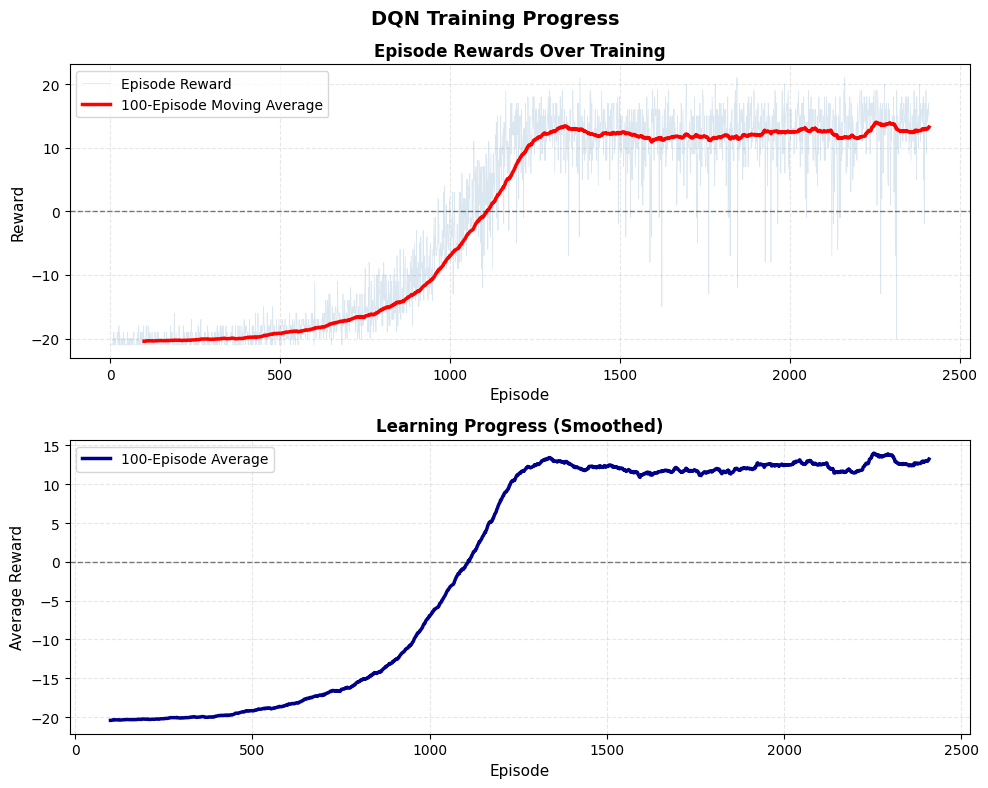

Total Episodes: 2409 | Recent Average (last 100): 13.24


In [13]:
# Plot Training Statistics - Report-Ready Visualizations

import matplotlib.pyplot as plt
import numpy as np
from collections import deque

# Check if episode_rewards exists
if 'episode_rewards' not in globals():
    print("⚠️  Training data not found. Please run the training cell first.")
else:
    # Convert deque to list if needed
    if isinstance(episode_rewards, deque):
        rewards_list = list(episode_rewards)
    else:
        rewards_list = episode_rewards
    
    if len(rewards_list) == 0:
        print("⚠️  No episode data available yet.")
    else:
        # Create figure with 2 subplots for report
        fig, axes = plt.subplots(2, 1, figsize=(10, 8))
        fig.suptitle('DQN Training Progress', fontsize=14, fontweight='bold')
        
        episodes = np.arange(1, len(rewards_list) + 1)
        
        # Plot 1: Episode Rewards with Moving Average
        ax1 = axes[0]
        ax1.plot(episodes, rewards_list, alpha=0.2, color='steelblue', linewidth=0.5, label='Episode Reward')
        
        # Calculate and plot 100-episode moving average
        window_size = 100
        if len(rewards_list) >= window_size:
            moving_avg = np.convolve(rewards_list, np.ones(window_size)/window_size, mode='valid')
            moving_avg_episodes = np.arange(window_size, len(rewards_list) + 1)
            ax1.plot(moving_avg_episodes, moving_avg, color='red', linewidth=2.5, 
                    label='100-Episode Moving Average')
        
        ax1.set_xlabel('Episode', fontsize=11)
        ax1.set_ylabel('Reward', fontsize=11)
        ax1.set_title('Episode Rewards Over Training', fontsize=12, fontweight='bold')
        ax1.grid(True, alpha=0.3, linestyle='--')
        ax1.legend(loc='best', fontsize=10)
        ax1.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
        
        # Plot 2: Smoothed Average Reward Curve
        ax2 = axes[1]
        
        # Plot 100-episode moving average
        if len(rewards_list) >= window_size:
            moving_avg = np.convolve(rewards_list, np.ones(window_size)/window_size, mode='valid')
            moving_avg_episodes = np.arange(window_size, len(rewards_list) + 1)
            ax2.plot(moving_avg_episodes, moving_avg, color='darkblue', linewidth=2.5,
                    label='100-Episode Average')
        
        ax2.set_xlabel('Episode', fontsize=11)
        ax2.set_ylabel('Average Reward', fontsize=11)
        ax2.set_title('Learning Progress (Smoothed)', fontsize=12, fontweight='bold')
        ax2.grid(True, alpha=0.3, linestyle='--')
        ax2.legend(loc='best', fontsize=10)
        ax2.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
        
        plt.tight_layout()
        plt.show()
        
        # Brief summary
        recent_avg = np.mean(rewards_list[-100:]) if len(rewards_list) >= 100 else np.mean(rewards_list)
        print(f"Total Episodes: {len(rewards_list)} | Recent Average (last 100): {recent_avg:.2f}")

In [ ]:
# Cell 8: Evaluation and Visualization - Simplified

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML, display

def make_eval_env(env_id='ALE/Pong-v5', render_mode='rgb_array'):
    """Create environment for evaluation with rendering."""
    base_env = gym.make(env_id, frameskip=1, repeat_action_probability=0.0, 
                       full_action_space=False, render_mode=render_mode)
    env = NoopResetEnv(base_env, noop_max=30)
    env = FireResetEnv(env)
    env = MaxAndSkipEnv(env, skip=4)
    env = WarpFrame(env)
    env = ClipRewardEnv(env)
    env = FrameStack(env, k=4)
    return env, base_env

def evaluate_and_visualize(model_path, n_episodes=1, max_steps=5000):
    """Evaluate model and show simple animated gameplay."""
    print(f"Loading model: {model_path}")
    
    if not os.path.exists(model_path):
        print(f"❌ Model not found: {model_path}")
        return
    
    # Setup environment and agent
    eval_env, base_env = make_eval_env('ALE/Pong-v5', render_mode='rgb_array')
    eval_agent = DQNAgent(n_actions=eval_env.action_space.n, device=device,
                         epsilon_start=0.0, epsilon_end=0.0, buffer_size=1000)
    eval_agent.load(model_path)
    eval_agent.q_network.eval()
    
    # Run episode and collect frames
    state, _ = eval_env.reset()
    frames = []
    total_reward = 0
    
    for step in range(max_steps):
        with torch.no_grad():
            state_tensor = torch.tensor(state, dtype=torch.uint8, device=device).unsqueeze(0)
            action = eval_agent.q_network(state_tensor).argmax(1).item()
        
        next_state, reward, terminated, truncated, _ = eval_env.step(action)
        total_reward += reward
        done = terminated or truncated
        
        # Capture frame
        frame = base_env.render()
        if frame is not None:
            frames.append(frame)
        
        if done:
            break
        state = next_state
    
    eval_env.close()
    base_env.close()
    
    print(f"Episode Reward: {total_reward:+.1f} | Steps: {len(frames)}")
    
    # Display animation
    if len(frames) > 0:
        # Downsample for smoother animation
        step = max(1, len(frames) // 200)
        frames_to_show = frames[::step]
        
        fig, ax = plt.subplots(figsize=(8, 6))
        ax.axis('off')
        ax.set_title(f'DQN Playing Pong (Reward: {total_reward:+.1f})', fontsize=12, fontweight='bold')
        
        im = ax.imshow(frames_to_show[0])
        
        def animate(i):
            im.set_array(frames_to_show[i % len(frames_to_show)])
            return [im]
        
        anim = animation.FuncAnimation(fig, animate, frames=len(frames_to_show), 
                                       interval=50, blit=True, repeat=True)
        plt.close()
        display(HTML(anim.to_jshtml()))
        print("Displaying animation")

print("Ready! Usage: evaluate_and_visualize('models/dqn_pong_final.pth')")


✅ Ready! Usage: evaluate_and_visualize('models/dqn_pong_final.pth')


In [15]:
# Example: Watch the DQN play!
# Uncomment to run:

evaluate_and_visualize('models/dqn_pong_final.pth')


Loading model: models/dqn_pong_final.pth
Episode Reward: +20.0 | Steps: 1625


✅ Animation displayed!
